In [1]:
import numpy as np
import jax.numpy as jnp
import dill
import sys
import os
sys.path.append(os.path.expanduser('~') + '/igm_emulator/igm_emulator/emulator')
from emulator_run import nn_emulator
sys.path.append(os.path.expanduser('~') + '/wdm/correlation')
import matplotlib.pyplot as plt
import h5py
import IPython
sys.path.append(os.path.expanduser('~') + '/igm_emulator/igm_emulator/hmc')
from nn_hmc_3d_x import NN_HMC_X

64


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Training for small bin: True
Layers: [100, 100, 100, 59]
Activation: <PjitFunction of <function leaky_relu at 0x7fbe5f86d040>>
L2 regularization lambda: 0.0001
meanX = [8.010e-02 9.149e+03 1.352e+00]
stdX = [1.67055380e-02 5.50374022e+03 6.02494813e-01]
train: (768, 3)
(358, 59)
<KeysViewHDF5 ['data', 'haiku_nn', 'performance']>
64


## Read in smaller bin parameters and mock data

In [2]:
true_temp_idx = 11
true_gamma_idx = 4
true_fobs_idx = 7
n_inference = 5

# small bin 4 -> 3
zstr = 'z54'
skewers_per_data = 20 #17->20
n_covar = 500000
bin_label = '_set_bins_3'
in_path_molly = f'/mnt/quasar2/mawolfson/correlation_funct/temp_gamma/final_135/{zstr}/' 
#change path from f'/mnt/quasar2/mawolfson/correlation_funct/temp_gamma/final/{z_string}/final_135/'

# get initial grid
in_name_h5py = f'correlation_temp_fluct_skewers_2000_R_30000_nf_9_dict{bin_label}.hdf5'
with h5py.File(in_path_molly + in_name_h5py, 'r') as f:
    params = dict(f['params'].attrs.items())
fobs = params['average_observed_flux']
R_value = params['R']
v_bins = params['v_bins']
t_0s = 10.**params['logT_0']
gammas = params['gamma']
n_temps = len(t_0s)
n_gammas = len(gammas)
n_f = len(fobs)

noise_idx = 0
like_name_0 = f'likelihood_dicts_R_30000_nf_9_T{true_temp_idx}_G{true_gamma_idx}_SNR0_F{true_fobs_idx}_ncovar_500000_P{skewers_per_data}{bin_label}.p'
like_dict_0 = dill.load(open(in_path_molly + like_name_0, 'rb'))
in_name_new_params = f'new_covariances_dict_R_30000_nf_9_ncovar_{n_covar}_' \
                     f'P{skewers_per_data}{bin_label}_params.p'
new_param_dict = dill.load(open(in_path_molly + in_name_new_params, 'rb'))
new_temps = new_param_dict['new_temps']
new_gammas = new_param_dict['new_gammas']
new_fobs = new_param_dict['new_fobs']

n_new_t = (len(new_temps) - 1)/(len(t_0s) - 1) - 1
n_new_g = (len(new_gammas) - 1)/(len(gammas) - 1) - 1
n_new_f = (len(new_fobs) - 1)/(len(fobs) - 1) - 1
new_models_np = np.empty([len(new_temps), len(new_gammas), len(new_fobs), len(v_bins)])

for old_t_below_idx in range(n_temps - 1):
    print(f'{old_t_below_idx / (n_temps - 1) * 100}%')
    for old_g_below_idx in range(n_gammas - 1):
        for old_f_below_idx in range(n_f - 1):
            fine_dict_in_name = f'new_covariances_dict_R_{int(R_value)}_nf_{n_f}_T{old_t_below_idx}_' \
                                f'G{old_g_below_idx}_SNR0_F{old_f_below_idx}_ncovar_{n_covar}_' \
                                f'P{skewers_per_data}{bin_label}.p'
            fine_dict = dill.load(open(in_path_molly + fine_dict_in_name, 'rb'))
            new_temps_small = fine_dict['new_temps']
            new_gammas_small = fine_dict['new_gammas']
            new_fobs_small = fine_dict['new_fobs']
            new_models_small = fine_dict['new_models']
            new_covariances_small = fine_dict['new_covariances']
            new_log_dets_small = fine_dict['new_log_dets']
            if old_t_below_idx == n_temps - 2:
                added_t_range = n_new_t + 2
            else:
                added_t_range = n_new_t + 1
            if old_g_below_idx == n_gammas - 2:
                added_g_range = n_new_g + 2
            else:
                added_g_range = n_new_g + 1
            if old_f_below_idx == n_f - 2:
                added_f_range = n_new_f + 2
            else:
                added_f_range = n_new_f + 1
            # print(added_f_range)
            for added_t_idx in range(int(added_t_range)):
                for added_g_idx in range(int(added_g_range)):
                    for added_f_idx in range(int(added_f_range)):
                        final_t_idx = int((old_t_below_idx * (n_new_t + 1)) + added_t_idx)
                        final_g_idx = int((old_g_below_idx * (n_new_g + 1)) + added_g_idx)
                        final_f_idx = int((old_f_below_idx * (n_new_f + 1)) + added_f_idx)
                        new_models_np[final_t_idx, final_g_idx, final_f_idx, :] = new_models_small[added_t_idx, added_g_idx, added_f_idx, :]
new_models = jnp.array(new_models_np)

0.0%
7.142857142857142%
14.285714285714285%
21.428571428571427%
28.57142857142857%
35.714285714285715%
42.857142857142854%
50.0%
57.14285714285714%
64.28571428571429%
71.42857142857143%
78.57142857142857%
85.71428571428571%
92.85714285714286%


In [3]:
print(fobs)

[0.0557 0.0618 0.0679 0.074  0.0801 0.0862 0.0923 0.0984 0.1045]


## Fine grid

In [4]:
temps_plot = np.empty([(n_temps-1) * 4 + 1])
for idx, temp in enumerate(t_0s[:-1]):
    new_idx = idx * 4
    for new_add_idx in range(4):
        temps_plot[new_idx + new_add_idx] = temp + (np.diff(t_0s)[idx] * new_add_idx / 4.)
temps_plot[-1] = t_0s[-1]

gammas_plot = np.empty([(n_gammas-1) * 4 + 1])
for idx, gamma in enumerate(gammas[:-1]):
    new_idx = idx * 4
    for new_add_idx in range(4):
        gammas_plot[new_idx + new_add_idx] = gamma + (np.diff(gammas)[idx] * new_add_idx / 4.)
gammas_plot[-1] = gammas[-1]

fobs_plot = np.empty([(n_f-1) * 4 + 1])
for idx, fob in enumerate(fobs[:-1]):
    new_idx = idx * 4
    for new_add_idx in range(4):
           fobs_plot[new_idx + new_add_idx] = fob + (np.diff(fobs)[idx] * new_add_idx / 4.)
fobs_plot[-1] = fobs[-1]

print(temps_plot.shape,gammas_plot.shape,fobs_plot.shape)

(57,) (33,) (33,)


## Molly's model

In [5]:
def return_idx(value, all_values):
    the_min_value = jnp.min(all_values)
    the_range = jnp.max(all_values) - the_min_value
    scaled_value = (value - the_min_value) / the_range * (len(all_values) - 1)
    nearest_idx = int(jnp.round(scaled_value))
    return nearest_idx
def get_molly_model_nearest(theta,
                                  fine_temps=new_temps, fine_gammas=new_gammas, fine_fobs=new_fobs,
                                  fine_models=new_models):
    temp, gamma, ave_f = theta
    temp_idx = return_idx(temp, fine_temps)
    gamma_idx = return_idx(gamma, fine_gammas)
    fobs_idx = return_idx(ave_f, fine_fobs)
    model = fine_models[temp_idx, gamma_idx, fobs_idx, :]
    return model
def log_likelihood_molly(theta, corr, theta_covariance=like_dict_0['covariance']
                         , true_log_det=like_dict_0['log_determinant']):
    # temp, g, ave_f = theta
    model = get_molly_model_nearest(theta)
    diff = corr - model
    nbins = len(corr)
    log_like = -(jnp.dot(diff, jnp.linalg.solve(theta_covariance, diff)) + true_log_det + nbins * jnp.log(2.0 * jnp.pi)) / 2.0
    return diff.mean(), log_like

## Linda's model

In [6]:
# get Linda's model 
#temp, gamma, ave_f = theta

sys.path.append(os.path.expanduser('~') + '/igm_emulator/igm_emulator/hmc')
from nn_hmc_3d_x import NN_HMC_X

in_path_linda = '/mnt/quasar2/zhenyujin/igm_emulator/emulator/best_params/'
emu_name = f'{zstr}_best_param_training_768_bin59.p' #small bins
best_params = dill.load(open(in_path_linda + emu_name, 'rb'))
nn_x = NN_HMC_X(v_bins, best_params, t_0s, gammas, fobs, like_dict_0)

def get_linda_model(theta, best_params_function=best_params):
    theta_linda = (theta[2], theta[0], theta[1])
    model = nn_emulator(best_params_function, theta_linda)
    return model

def log_likelihood(theta, corr):
        '''
        Args:
            x: dimensionless parameters
            flux: observed flux
        Returns:
            log_likelihood: log likelihood
        '''
        model = get_linda_model(theta) #theta is in physical dimension for this function
        #model = get_molly_model_nearest(theta) #replace same model

        new_covariance = nn_x.like_dict['covariance']
        log_determinant = nn_x.like_dict['log_determinant']

        diff = corr - model
        nbins = len(nn_x.vbins)
        log_like = -(jnp.dot(diff, jnp.linalg.solve(new_covariance, diff)) + log_determinant + nbins * jnp.log(
            2.0 * jnp.pi)) / 2.0
        #print(f'Log_likelihood={log_like}')
        return diff.mean(), log_like

def log_likelihood_linda(theta, corr):
    theta = np.array(theta)
    theta_linda = (theta[2], theta[0], theta[1])
    theta_linda_x = nn_x.theta_to_x(theta_linda)
    return nn_x.log_likelihood(theta_linda_x, corr)

# read in the mock data
mock_name = f'mocks_R_{int(R_value)}_nf_{n_f}_T{true_temp_idx}_G{true_gamma_idx}_SNR{noise_idx}_F{true_fobs_idx}_P{skewers_per_data}{bin_label}.p'
mocks = dill.load(open(in_path_molly + mock_name, 'rb'))

In [7]:
sample = [t_0s[true_temp_idx],gammas[true_gamma_idx],fobs[true_fobs_idx]]
n_samples = 5
for mock_idx in range(2):
    print(log_likelihood(sample,mocks[mock_idx]))
    print(log_likelihood_linda(sample,mocks[mock_idx]))

(Array(-0.00024237, dtype=float64), Array(442.41119002, dtype=float64))
442.4111900192269
(Array(-0.00185575, dtype=float64), Array(443.18673376, dtype=float64))
443.1867337587681


## Plot chi for two models

In [13]:
emu_path = os.path.expanduser('~') + f'/igm_emulator/igm_emulator/emulator/best_params/'
#change retrain param
with h5py.File(emu_path+'z5.4_nn_bin59_savefile.hdf5', 'r') as f:
    # IPython.embed()
    residual = np.asarray(f['performance']['residuals'])
    meanY = np.asarray(f['data']['meanY'])
    stdY = np.asarray(f['data']['stdY'])
    print(f['data'].keys())
    print(f['performance'].attrs.keys())

dir_lhs = os.path.expanduser('~') + '/igm_emulator/igm_emulator/emulator/GRID/'

test_num = '_test_89_bin59'
Y_test = dill.load(open(dir_lhs + f'{zstr}_model{test_num}.p', 'rb'))
X_test = dill.load(open(dir_lhs + f'{zstr}_param{test_num}.p', 'rb'))
#Y_test = (Y_test - meanY) / stdY

diff = residual * Y_test
chi2 = 0
chi = []
rel_err = []
chi2_molly = 0
chi_molly = []
rel_err_molly = []
print(diff.shape)
for d_i in range(Y_test.shape[0]):
    d = Y_test[d_i,:] - get_linda_model([X_test[d_i,1],X_test[d_i,2],X_test[d_i,0]])
    chi2=+jnp.dot(d, jnp.linalg.solve(like_dict_0['covariance'], d))
    #chi.append(jnp.linalg.solve(jnp.sqrt(like_dict_0['covariance']), d))
    chi.append(np.multiply(np.diagonal(like_dict_0['covariance']), d))
    rel_err.append(d/Y_test[d_i,:]*100)
    
    diff_molly = Y_test[d_i,:] - get_molly_model_nearest([X_test[d_i,1],X_test[d_i,2],X_test[d_i,0]])
    chi2_molly=+(jnp.dot(diff_molly, jnp.linalg.solve(like_dict_0['covariance'], diff_molly)))
    #chi_molly.append(jnp.linalg.solve(jnp.sqrt(like_dict_0['covariance']), diff_molly))
    chi_molly.append(np.multiply(np.diagonal(like_dict_0['covariance']), diff_molly))
    rel_err_molly.append(diff_molly/Y_test[d_i,:]*100)
    #print(diff_molly/Y_test[d_i,:]<=0)
chi = np.array(chi).T
chi_molly = np.array(chi_molly).T
rel_err = np.array(rel_err).T
rel_err_molly = np.array(rel_err_molly).T

chi2_dof = chi2/Y_test.shape[1]
chi2_molly_dof = chi2_molly/Y_test.shape[1]
print(f'chi2 square emulator: {chi2_dof},chi2 square molly: {chi2_molly_dof}')

<KeysViewHDF5 ['meanX', 'meanY', 'stdX', 'stdY', 'test_data', 'train_data', 'vali_data']>
<KeysViewHDF5 ['R2', 'residuals_results', 'test_loss', 'train_loss', 'vali_loss']>
(89, 59)
chi2 square emulator: 0.11487931781274179,chi2 square molly: 0.0


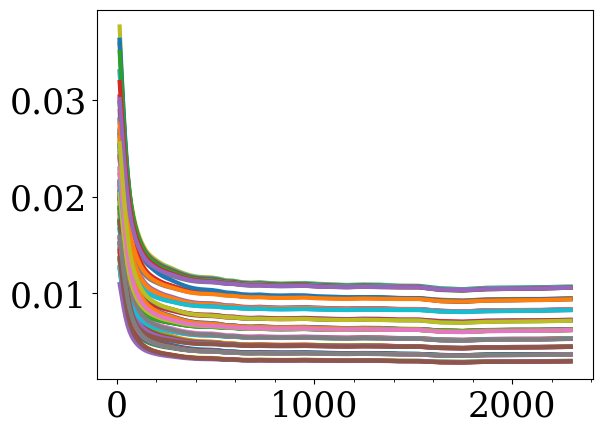

In [9]:
plt.plot(v_bins,Y_test.T)

plt.show()

In [10]:
with h5py.File(emu_path+'z5.4_nn_bin59_savefile.hdf5', 'r') as f:
    print('smaller bin')
    print(f['performance'].attrs['residuals_results'])
    print(f['performance'].attrs['R2'])

with h5py.File(emu_path+'z5.4_nn_savefile.hdf5', 'r') as f:
    print('larger bin')
    print(f['performance'].attrs['residuals_results'])
    print(f['performance'].attrs['R2'])

smaller bin
0.08468058282781929% +/- 0.4667117098554442%
0.9998149090813204
larger bin
0.026061927159740227% +/- 0.4202427281480411%
0.9996476034059566


print(chi.shape, rel_err_molly.shape)
rel_molly_mean = np.mean(rel_err_molly,axis=0)
print(np.where(rel_molly_mean==rel_molly_mean.min()))

Text(0, 0.5, 'Relative error (%)')

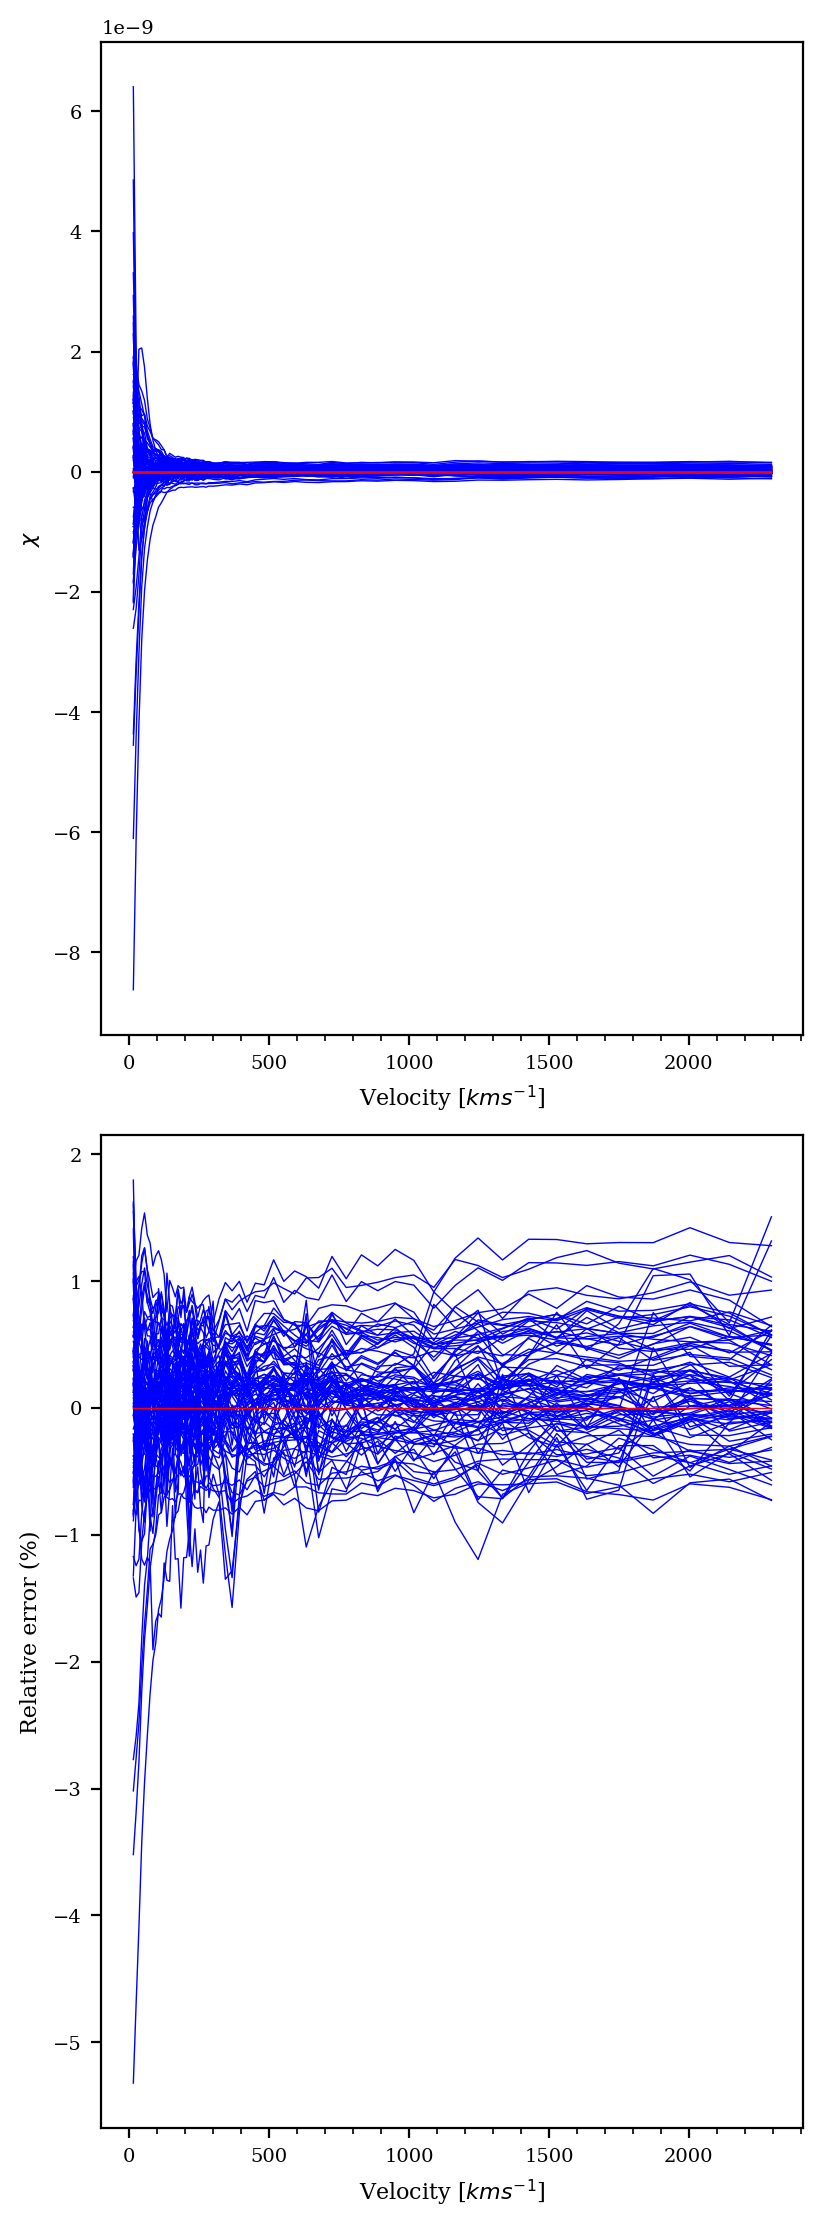

In [22]:
x_size = 4
dpi_value = 200
plt_params = {'legend.fontsize': 7,
              'legend.frameon': False,
              'axes.labelsize': 8,
              'axes.titlesize': 6.5,
              'figure.titlesize': 8,
              'xtick.labelsize': 7,
              'ytick.labelsize': 7,
              'lines.linewidth': 1,
              'lines.markersize': 2,
              'errorbar.capsize': 3,
              'font.family': 'serif',
              # 'text.usetex': True,
              'xtick.minor.visible': True,
              }
plt.rcParams.update(plt_params)

plt.figure(figsize=(x_size, x_size*4), constrained_layout=True,
                                dpi=dpi_value)

fig1 = plt.subplot(3,1,1)
fig1.plot(v_bins, chi, linewidth=0.5, color = 'b'#, alpha=0.2
         ,label='Linda'
        )
fig1.plot(v_bins, chi_molly, linewidth=0.5, color = 'r', alpha=0.2
         ,label='Molly'
        )
fig1.set_xlabel(r'Velocity [$km s^{-1}$]')
fig1.set_ylabel(r'$\chi$')
#plt.title(f'%Residual plot:mean: {np.mean(diff)}; std: {np.std(diff)}')

fig2 = plt.subplot(3,1,2)
fig2.plot(v_bins, rel_err, linewidth=0.5, color = 'b'#, alpha=0.2
         #,label='linda'
        )
fig2.plot(v_bins, rel_err_molly[:,32], linewidth=0.5, color = 'r'#, alpha=0.2
         #,label='molly'
        )
#fig2.plot(v_bins, residual.T, linewidth=0.5, color = 'g', alpha=0.2
         #,label='molly'
        #)
fig2.set_xlabel(r'Velocity [$km s^{-1}$]')
fig2.set_ylabel(r'Relative error (%)')

In [ ]:
print(X_test[:10,:])

In [ ]:
plt.plot(v_bins,get_molly_model_nearest([X_test[:,1],X_test[:,2],X_test[:,0]]),label='molly')
plt.plot(v_bins,Y_test.T,label='test')

plt.legend()

In [ ]:
from matplotlib import cm
colormap = cm.Reds
n = 3
percentiles = [68,95,99]
rel_err_perc= np.zeros((59,n))
rel_err_molly_perc = np.zeros((59,n))

for i in range(n):
    rel_err_perc[:,i]=np.percentile(rel_err,percentiles[i],axis=1)
    rel_err_molly_perc[:,i]=np.percentile(rel_err_molly,percentiles[i],axis=1)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8,8))
for i in range(n):
    ax[0].fill_between(v_bins, rel_err_perc[:,i],color=colormap(i/n),zorder=-i,label=f'{percentiles[i]}%')
    ax[1].fill_between(v_bins, rel_err_molly_perc[:,i],color=colormap(i/n),zorder=-i)
ax[0].set_title("Percentile plot", fontsize=15)
ax[0].tick_params(labelsize=11.5)
ax[1].set_xlabel(r'Velocity [$km s^{-1}$]', fontsize=14)
ax[0].set_ylabel(r'Relative error Emulator(%)', fontsize=10)
ax[1].set_ylabel(r'Relative error Molly(%)', fontsize=10)
fig.tight_layout()
fig.legend()

## Plot likelihood slice shape in smaller bin retrained emulator

In [ ]:
n_inference = 5
temps_grid = temps_plot #(57,)
gammas_grid = gammas_plot #(33,)
fobs_grid = fobs_plot #(33,)

# plot one 1d slice of likelihood - temps only
g_plot_idx = int(np.floor(len(gammas_grid)/2.))
f_plot_idx = int(np.floor(len(fobs_grid)/2.))
t_plot_idx = int(np.floor(len(temps_grid)/2.))
print(g_plot_idx,f_plot_idx)


In [ ]:
molly_log_likelihood_temp=np.empty([n_inference,len(temps_grid)])
linda_log_likelihood_temp=np.empty([n_inference,len(temps_grid)])
for mock_idx in range(n_inference):
    for i,temp in enumerate(temps_grid):
        molly_log_likelihood_temp[mock_idx,i] = log_likelihood_molly([temp, gammas_grid[g_plot_idx],fobs_grid[f_plot_idx]],mocks[mock_idx])[1]
        linda_log_likelihood_temp[mock_idx,i] = log_likelihood([temp, gammas_grid[g_plot_idx],fobs_grid[f_plot_idx]],mocks[mock_idx])[1]

molly_log_likelihood_gamma=np.empty([n_inference,len(gammas_grid)])
linda_log_likelihood_gamma=np.empty([n_inference,len(gammas_grid)])
for mock_idx in range(n_inference):
    for i,g in enumerate(gammas_grid):
        molly_log_likelihood_gamma[mock_idx,i] = log_likelihood_molly([temps_grid[t_plot_idx], g,fobs_grid[f_plot_idx]],mocks[mock_idx])[1]
        linda_log_likelihood_gamma[mock_idx,i] = log_likelihood([temps_grid[t_plot_idx], g,fobs_grid[f_plot_idx]],mocks[mock_idx])[1]

molly_log_likelihood_fob=np.empty([n_inference,len(fobs_grid)])
linda_log_likelihood_fob=np.empty([n_inference,len(fobs_grid)])
for mock_idx in range(n_inference):
    for i,f in enumerate(fobs_grid):
        molly_log_likelihood_fob[mock_idx,i] = log_likelihood_molly([temps_grid[t_plot_idx], gammas_grid[g_plot_idx],f],mocks[mock_idx])[1]
        linda_log_likelihood_fob[mock_idx,i] = log_likelihood([temps_grid[t_plot_idx], gammas_grid[g_plot_idx],f],mocks[mock_idx])[1]
        

# IPython.embed()
likelihood_fig = plt.figure(figsize=(x_size, x_size*.77*5.*.5), constrained_layout=True,
                                dpi=dpi_value,
                                )
grid = likelihood_fig.add_gridspec(
    nrows=5, ncols=3
)
for mock_idx in range(n_inference):
    axes1 = likelihood_fig.add_subplot(grid[mock_idx,0])
    axes1.plot(temps_grid, linda_log_likelihood_temp[mock_idx,:],'r')
    axes1.plot(temps_grid, molly_log_likelihood_temp[mock_idx,:],'--')
    axes1.set_ylabel('log likelihood')
    axes1.set_title(f'mock {mock_idx}')
axes1.set_xlabel('$T_0$ (K)')

for mock_idx in range(n_inference):
    axes2 = likelihood_fig.add_subplot(grid[mock_idx,1])
    axes2.plot(gammas_grid, linda_log_likelihood_gamma[mock_idx,:],'r')
    axes2.plot(gammas_grid, molly_log_likelihood_gamma[mock_idx,:],'--')
    axes2.set_ylabel('log likelihood')
    axes2.set_title(f'mock {mock_idx}')
axes2.set_xlabel('$Gamma$')

for mock_idx in range(n_inference):
    axes3 = likelihood_fig.add_subplot(grid[mock_idx,2])
    axes3.plot(fobs_grid, linda_log_likelihood_fob[mock_idx,:],'r')
    axes3.plot(fobs_grid, molly_log_likelihood_fob[mock_idx,:],'--')
    axes3.set_ylabel('log likelihood')
    axes3.set_title(f'mock {mock_idx}')
axes3.set_xlabel('$<F>$')

## Plot models at peak points

In [ ]:
t_idx_1 = int(np.floor(len(temps_grid)/4.))
t_idx_2 = int(np.floor(len(temps_grid)*3/4.))
temperature_want = 10000.
theta_want_1 = (temps_grid[t_idx_1], gammas_grid[g_plot_idx],fobs_grid[f_plot_idx])
theta_want_2 = (temps_grid[t_idx_2], gammas_grid[g_plot_idx],fobs_grid[f_plot_idx])
theta_want_3 = (10000, gammas_grid[g_plot_idx],fobs_grid[f_plot_idx])


model_molly_1 = get_molly_model_nearest(theta_want_1)
model_linda_1 = get_linda_model(theta_want_1)
model_molly_2 = get_molly_model_nearest(theta_want_2)
model_linda_2 = get_linda_model(theta_want_2)
model_molly_3 = get_molly_model_nearest(theta_want_3)
model_linda_3 = get_linda_model(theta_want_3)

model_fig = plt.figure(figsize=(x_size, x_size*.77*.5), constrained_layout=True,
                                dpi=dpi_value,
                                )
# one_correlation_fig.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0, wspace=0)
grid = model_fig.add_gridspec(
    nrows=1, ncols=1, # width_ratios=[20, 20, 20, 20, 20, 1],
)
axes = model_fig.add_subplot(grid[0])
axes.plot(v_bins, model_molly_1, label='molly_1')
axes.plot(v_bins, model_linda_1,label='linda_1')
axes.plot(v_bins, model_molly_2,'--', label='molly_2')
axes.plot(v_bins, model_linda_2, '--',label='linda_2')
axes.plot(v_bins, get_molly_model_nearest(theta_want_3),'--', label='molly_3')
axes.plot(v_bins, get_linda_model(theta_want_3), '--',label='linda_3')
axes.plot(v_bins, mocks[1], label='mock_1')

axes.legend()
plt.show()

In [ ]:
chi_1=jnp.linalg.solve(jnp.sqrt(like_dict_0['covariance']), mocks[1]-model_linda_1)
chi_2=jnp.linalg.solve(jnp.sqrt(like_dict_0['covariance']), mocks[1]-model_linda_2)
chi_3=jnp.linalg.solve(jnp.sqrt(like_dict_0['covariance']), mocks[1]-model_linda_3)

chi_1_=jnp.linalg.solve(jnp.sqrt(like_dict_0['covariance']), mocks[1]-model_molly_1)
chi_2_=jnp.linalg.solve(jnp.sqrt(like_dict_0['covariance']), mocks[1]-model_molly_2)
chi_3_=jnp.linalg.solve(jnp.sqrt(like_dict_0['covariance']), mocks[1]-model_molly_3)
plt.figure(figsize=(10, 10))
plt.plot(v_bins,chi_1,color='b',label='l1',alpha=0.3)
plt.plot(v_bins,chi_2,color='g',label='l2',alpha=0.3)
plt.plot(v_bins,chi_3,color='r',label='l3',alpha=0.3)
plt.plot(v_bins,chi_1_,'--',color='b', label='m1')
plt.plot(v_bins,chi_2_,'--',color='g',label='m2')
plt.plot(v_bins,chi_3_,'--',color='r',label='m3')
plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(v_bins,100*(mocks[1]-model_linda_1)/mocks[1],color='b',label='l1',alpha=0.3)
plt.plot(v_bins,100*(mocks[1]-model_linda_2)/mocks[1],color='g',label='l2',alpha=0.3)
plt.plot(v_bins,100*(mocks[1]-model_linda_3)/mocks[1],color='r',label='l3',alpha=0.3)
plt.plot(v_bins,100*(mocks[1]-model_molly_1)/mocks[1],'--',color='b', label='m1')
plt.plot(v_bins,100*(mocks[1]-model_molly_2)/mocks[1],'--',color='g',label='m2')
plt.plot(v_bins,100*(mocks[1]-model_molly_3)/mocks[1],'--',color='r',label='m3')
plt.xscale('log')
plt.ylabel('percentage relative error (%)')
plt.legend()
plt.show()

## Print evidence of HMC

In [ ]:
test_id = 15
molly_name = f'z54_data_nearest_model_set_bins_4_steps_48000_mcmc_inference_5_one_prior_T{true_temp_idx}_G{true_gamma_idx}_F{true_fobs_idx}_R_30000.hdf5'
molly_hmc = h5py.File(f'/mnt/quasar2/mawolfson/correlation_funct/temp_gamma/final/{zstr}/final_135/' + molly_name, 'r')
for mock_idx in range(n_inference): 
    molly_sample = molly_hmc['samples'][mock_idx,:,:]
    molly_flip = np.zeros(shape = molly_sample.shape)
    molly_flip[:,0] = molly_sample[:,2]
    molly_flip[:,1] = molly_sample[:,0]
    molly_flip[:,2] = molly_sample[:,1]
    t_molly, g_molly, f_molly = map(lambda v: (v[1], v[2] - v[1], v[1] - v[0]),
                                     zip(*np.percentile(molly_sample, [16, 50, 84], axis=0)))
    molly_infer = get_molly_model_nearest([t_molly[0], g_molly[0],f_molly[0]])
    
    linda_name = f"jit_2000_4_test{test_id}_small_bins_compare_molly_mock{mock_idx}"
    linda_hmc = h5py.File(os.path.expanduser('~') + f'/igm_emulator/igm_emulator/hmc/hmc_results/' +f'{zstr}_F{true_fobs_idx}_T0{true_temp_idx}_G{true_gamma_idx}_{linda_name}_hmc_results.hdf5', 'r')
    
    molly_evidence = np.sum(molly_hmc['log_prob'][mock_idx,:])
    linda_evidence = np.sum(linda_hmc['lnP'])
    print(f'molly_evidence: {molly_evidence}, linda_evidence: {linda_evidence}')
                      